In [1]:
from pymongo import MongoClient
from sys import getsizeof
import numpy as np 
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from sympy import degree
from tqdm import tqdm
import math
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import linregress
import powerlaw as plw
from reddit import plotting
from reddit import datahandling as dh
%load_ext autoreload
%autoreload 2

In [2]:
#networkx graph design
options = {
    #'node_color': 'red',
    'node_size': 1,
    'width': 0.2,
    'arrowsize': 2
}

In [3]:
client = MongoClient('localhost', 27017)
db = client.reddit
start = 1577836800
end = 1580515200
def getPipeline(subreddit, start, end):
    pipeline = [
        {'$project': {'_id': 0, 'link_id':0, 'score':0}},#  'id': 1, 'subreddit': 1, 'parent_id': 1, 'author': 1}}, 
        {'$match': {'subreddit': subreddit,'created_utc':{ '$gt': start, '$lt': end },'author': {'$ne': '[deleted]'}}},
        #{'$limit': 10000},
        {'$project': {'subreddit': 0}},
        {'$sort': {'id':1}}
    ]
    return pipeline

def getDataframe(db, subreddit, start, end, which='both'):
    """
	Loads data from given subreddit from database and packs into dataframe
	Args:
		subreddit:
		start:
		end:
        which: 
	Returns:
        Dataframe for given parameters
	"""
    ### Load Database and apply pipeline, assign unique index to each user
    if which != 'both':
        collection = db[which]
        cursor = collection.aggregate(getPipeline(subreddit,start,end))
        #cursor = collection.find({'subreddit':subreddit}).hint('Interactions')
        df = pd.DataFrame(list(cursor))
        df.drop(columns=['subreddit','score', 'link_id','_id','created_utc','num_comments','domain'], errors='ignore', inplace=True)
        if which == 'submissions':
            df.insert(2, 'parent_id', '')

    else:
        df_sub = getDataframe(subreddit, which='submissions')
        df_com = getDataframe(subreddit,which='comments')
        df = pd.concat([df_sub,df_com])
    df['id'] = df['id'].astype('string') 
    df['parent_id'] = df['parent_id'].astype('string').str.replace('t3_','')
    df['parent_id'] = df['parent_id'].astype('string').str.replace('t1_','')
    return df
    
def getMyParents(df):
    """
	Args:
		df:
	Returns:
        numpy array with parent user id
	"""
    df['user_id'] = df.groupby('author').ngroup()    ##Add user id
    df['parent_user_id'] = pd.Series(dtype=int)
    df = df.assign(parent_user_id = -1)
    df_array = df.to_numpy()
    del(df)
    for i,li in tqdm(enumerate(df_array[:,2])): #iterate over posts link id
        pos = np.searchsorted(df_array[:,1],li)
        if pos != df_array.shape[0]:
            if li == df_array[pos,1]:
                df_array[i,4] = df_array[pos,3]
    return df_array

def getData(db,subreddit,start,end,which):
    try:
        data = np.load('./arrays/{}jan2020.npy'.format(subreddit), allow_pickle=True)
    except:
        print('Subreddit not analyzed yet. Generating new array. This may take a while...')
        df = getDataframe(db,subreddit,start,end,'comments')
        data = getMyParents(df)
        del(df)
        np.save('./arrays/{}jan2020.npy'.format(subreddit), data)
    return data

In [7]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

Subreddit: counting, Top 10 outlier authors: ['mistyskye14' 'Zaajdaeon' 'RandomMarimbist' 'timo78888' 'mistyskye14'
 'mistyskye14' 'colby6666' 'colby6666' 'llamasR5life' 'mistyskye14']
Subreddit: churning, Top 10 outlier authors: ['dennis_the_menace253' 'curiousgeorge498' 'RaulDukes' 'nalzuabi'
 'sl1pshade' 'churnchurnchurning' 'hythloth' 'LooseTone' 'shakesbusiness'
 'mikep4']
Subreddit: MachineLearning, Top 10 outlier authors: ['sinashish' 'ian_williamson' 'mongoosefist' 'i_love_FFT' 'DanielWicz'
 'anasuna' 'snowball_antrobus' 'Brainsonastick' 'AlleUndKalle'
 'local-minima']
Subreddit: washingtondc, Top 10 outlier authors: ['jaddiya' 'DistrictOfDeutsch' 'nam3backward5' 'klubkouture' 'WetDog2019'
 'FreemanCantJump' 'ohmygodlinda' 'scotch_please' 'smkAce0921' 'celj1234']
Subreddit: askscience, Top 10 outlier authors: ['Notonfoodstamps' 'bullerick' 'koalasonic' 'greygringo' 'redduif'
 'chickenbarf' 'AskScienceModerator' 'Juswantedtono' 'BiologyJ'
 'AutoModerator']
Subreddit: personalfin

Text(0.5, 0.98, 'Based on Interactions in Februar 2020')

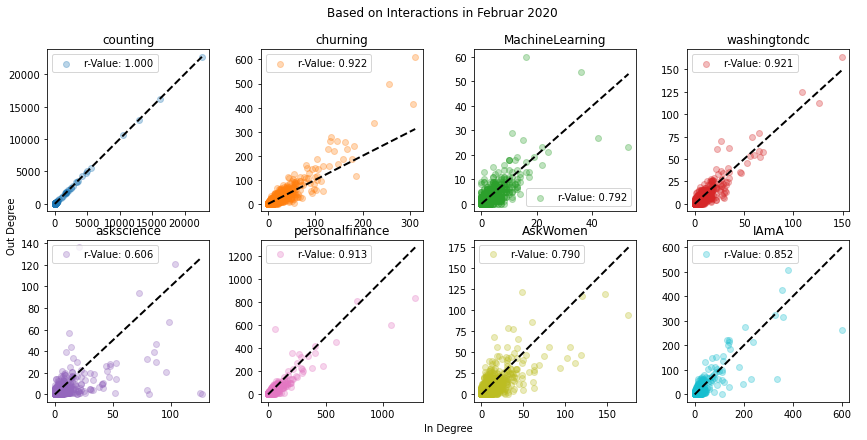

In [16]:
subreddits = ['counting', 'churning', 'MachineLearning', 'washingtondc', 'askscience', 'personalfinance', 'AskWomen', 'IAmA']#, 'AskMen']
fig, axis = plt.subplots(2,4)
fig.set_figheight(6)
fig.set_figwidth(12)
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
axis = axis.flatten()
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in enumerate(subreddits):
    data = getData(db,subreddit,start,end,'comments')
    num_users = data.shape[0]
    G = nx.MultiDiGraph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    in_degr = np.array(G.in_degree())[:,1]
    out_degr = np.array(G.out_degree())[:,1]
    dist = np.abs(in_degr-out_degr)
    ind = np.argpartition(dist, -10)[-10:]
    print('Subreddit: {}, Top 10 outlier authors: {}'.format(subreddit,data[ind,0]))
    plotting.plotdegrees(in_degr, out_degr, axis[idx], color=clr[idx], subreddit=subreddit)
    #del(data)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('In Degree')
plt.ylabel('Out Degree')
fig.suptitle('Based on Interactions in Februar 2020')
#plt.savefig('InOutDegr.png',facecolor='white', transparent=False)

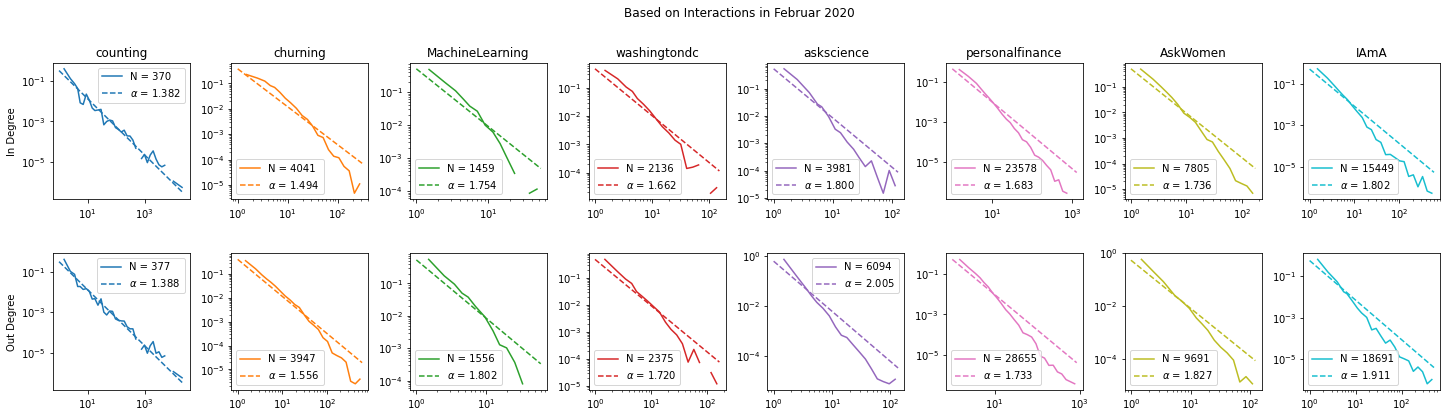

In [65]:
subreddits = ['counting', 'churning', 'MachineLearning', 'washingtondc', 'askscience', 'personalfinance', 'AskWomen', 'IAmA']
fig, axis = plt.subplots(2,8)
fig.set_figheight(6)
fig.set_figwidth(20)
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in enumerate(subreddits):
    data = getData(db,subreddit,start,end,'comments')
    num_users = data.shape[0]
    G = nx.MultiDiGraph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    in_degr = np.array(G.in_degree())[:,1]
    out_degr = np.array(G.out_degree())[:,1]
    plotting.plotpowerlaw(in_degr, axis[0,idx],color=clr[idx],xmin=1)
    plotting.plotpowerlaw(out_degr, axis[1,idx],color=clr[idx],xmin=1)
    axis[0,idx].set_title(subreddit)
    axis[0,idx].set_box_aspect(1)
    axis[1,idx].set_box_aspect(1)
axis[0,0].set_ylabel('In Degree')
axis[1,0].set_ylabel('Out Degree')
fig.suptitle('Based on Interactions in Februar 2020')
plt.savefig('InOutDegrHist.pdf')

Subreddit: counting, avg. num of tri.:73.87113402061856
Subreddit: MachineLearning, avg. num of tri.:0.2287480680061824
Subreddit: washingtondc, avg. num of tri.:1.1817864619678995
Subreddit: askscience, avg. num of tri.:0.14786275079965105
Subreddit: churning, avg. num of tri.:8.555294117647058
Subreddit: personalfinance, avg. num of tri.:0.7246336743157312
Subreddit: AskWomen, avg. num of tri.:0.2172848145556333
Subreddit: IAmA, avg. num of tri.:0.26780367139695355


Text(0.5, 0.98, 'Number of Triangles. Based on Interactions in Februar 2020')

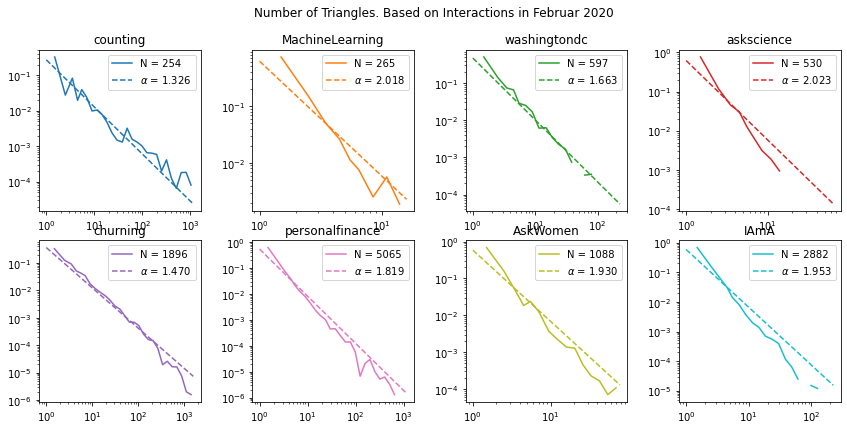

In [13]:
subreddits = ['counting', 'MachineLearning', 'washingtondc', 'askscience','churning', 'personalfinance', 'AskWomen', 'IAmA']
fig, axis = plt.subplots(2,4)
fig.set_figheight(6)
fig.set_figwidth(12)
axis = axis.flatten()
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in enumerate(subreddits):
    data = getData(db,subreddit,start,end,'comments')
    num_users = data.shape[0]
    G = nx.Graph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    G.remove_nodes_from(list(nx.isolates(G)))
    triangles = np.array(list(nx.triangles(G).items()))[:,1]
    print('Subreddit: {}, avg. num of tri.:{}'.format(subreddit,triangles.mean()))
    plotting.plotpowerlaw(triangles, axis[idx],color=clr[idx],xmin=1)
    axis[idx].set_title(subreddit)
    axis[idx].set_box_aspect(1)
fig.suptitle('Number of Triangles. Based on Interactions in Februar 2020')


Subreddit: counting, avg. clustering coeff.:0.5122812144041821
Subreddit: MachineLearning, avg. clustering coeff.:0.04169423680497401
Subreddit: washingtondc, avg. clustering coeff.:0.04460989629198405
Subreddit: askscience, avg. clustering coeff.:0.03037956746453827
Subreddit: churning, avg. clustering coeff.:0.07944861575838315
Subreddit: personalfinance, avg. clustering coeff.:0.04172851136699974
Subreddit: AskWomen, avg. clustering coeff.:0.02385795656048086
Subreddit: IAmA, avg. clustering coeff.:0.049885115628325635


Text(0.5, 0.98, 'Clustering Coefficients. Based on Interactions in Februar 2020')

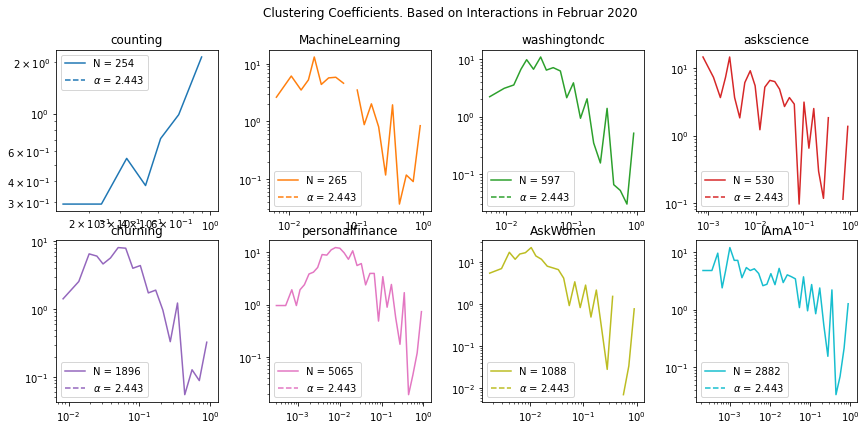

In [14]:
subreddits = ['counting', 'MachineLearning', 'washingtondc', 'askscience','churning', 'personalfinance', 'AskWomen', 'IAmA']#,# 'AskWomen', 'IAmA']
fig, axis = plt.subplots(2,4)
fig.set_figheight(6)
fig.set_figwidth(12)
axis = axis.flatten()
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in enumerate(subreddits):
    data = getData(db,subreddit,start,end,'comments')
    num_users = data.shape[0]
    G = nx.Graph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    G.remove_nodes_from(list(nx.isolates(G)))
    clust = np.array(list(nx.clustering(G).items()))[:,1]
    print('Subreddit: {}, avg. clustering coeff.:{}'.format(subreddit,clust.mean()))
    plotting.plotpowerlaw(clust, axis[idx], show_fit=True ,color=clr[idx])
    axis[idx].set_title(subreddit)
    axis[idx].set_box_aspect(1)
    #axis[idx].set_xscale('linear')
    #axis[idx].set_yscale('linear')
fig.suptitle('Clustering Coefficients. Based on Interactions in Februar 2020')


In [ ]:

subreddit = 'desmoines'
data = pd.DataFrame(columns=['inDegr', 'outDegr', 'triangles'])
df =  pd.read_pickle('dataframes/{}_dataframe.pkl'.format(subreddit))
num_users = int(df['user_id'].max())+1
#data['user_id'] = df['user_id'].unique()
#Get in and out degree of each node from directed mulitgraph
diG = nx.MultiDiGraph()
diG.add_nodes_from(np.arange(num_users+1))
for index, row in tqdm(df.iterrows()):
    if row['link_user_id'] != -1 and not math.isnan(row['link_user_id']) and not math.isnan(row['user_id']):
        diG.add_edge(row['user_id'],row['link_user_id'])
#diG.remove_nodes_from(list(nx.isolates(diG)))
print(nx.isolates(diG))
print(np.array(diG.in_degree())[:,0][np.array(diG.in_degree())[:,1]>10])
in_degr = np.array(diG.in_degree())[:,1]
out_degr = np.array(diG.out_degree())[:,1]

data['inDegr'] = in_degr
data['outDegr'] = out_degr
del(diG)

G = nx.Graph()
G.add_nodes_from(np.arange(num_users+1))
for index, row in tqdm(df.iterrows()):
    if row['link_user_id'] != -1 and not math.isnan(row['link_user_id']) and not math.isnan(row['user_id']):
        G.add_edge(row['user_id'],row['link_user_id'])
#G.remove_nodes_from(list(nx.isolates(G)))
triangles = np.array(list(nx.triangles(G).items()))[:,1]

data['triangles'] = triangles


3725it [00:00, 13796.96it/s]


<generator object isolates.<locals>.<genexpr> at 0x00000254549C33C0>
[  12   15   26   33   34   60   77   94  105  112  114  126  140  154
  169  194  199  203  225  269  297  312  321  352  360  405  426  433
  435  440  463  480  485  493  498  502  503  528  535  538  548  566
  589  591  595  596  597  598  601  623  624  638  642  673  679  690
  691  705  716  746  775  802  846  854  856  877  881  883  895  916
  929  932  951  952  955  958  972  995 1009]


3725it [00:00, 14434.71it/s]


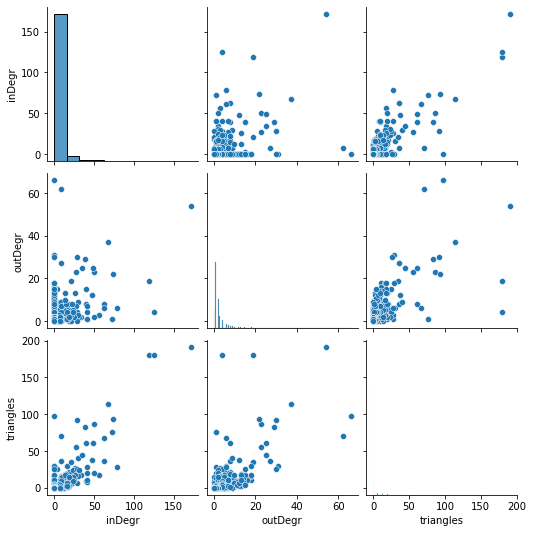

In [ ]:
sns.pairplot(data)

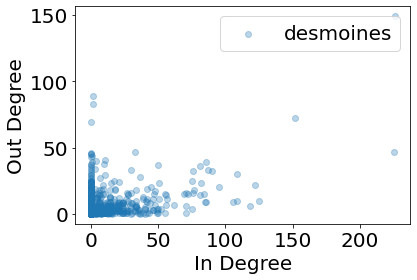

In [ ]:
plt.scatter(np.array(in_degr)[:,1],np.array(out_degr)[:,1], label = subreddit, alpha=0.3)
plt.xlabel('In Degree')
plt.ylabel('Out Degree')
plt.legend()
plt.show()

26174


26174it [02:37, 165.99it/s]
100%|██████████| 13224/13224 [00:00<00:00, 528836.94it/s]
26484it [00:01, 20120.10it/s]


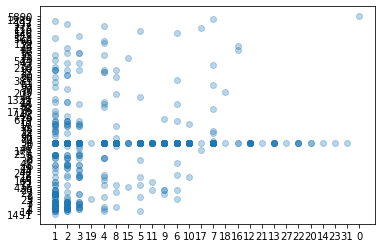

In [ ]:
subreddit = 'movies'
com_collection = db["comments"]
com_cursor = com_collection.aggregate(getPipeline(subreddit,start,end,False))
com_df = pd.DataFrame(list(com_cursor))
com_df = com_df.drop(columns=['subreddit','score', 'parent_id', '_id'])
sub_collection = db['submissions']
sub_cursor = sub_collection.aggregate(getPipeline(subreddit,start,end,True))
sub_df = pd.DataFrame(list(sub_cursor))
sub_df = sub_df.drop(columns=['subreddit','score','num_comments','domain', '_id'])

sub_df.insert(2, 'link_id', '')

df = pd.concat([sub_df,com_df])
#df['user_id'] = df.groupby('author').ngroup()
df['link_id'] = df['link_id'].astype('string').str.replace('t3_','')
#num_users = df['user_id'].max()+1
df['id'] = df['id'].astype('string') 
df['link_user'] = pd.Series(dtype=str)
df = df.assign(link_user = '')
df_dict = df.to_dict()
print(len(df['id']))
for i,li in tqdm(enumerate(df['link_id'])): #iterate over posts link id
    #link_user_id =  (df.loc[df['id'] == li, 'user_id']) #find the users id that corresponds to the link id
    #pos = df.loc[df['id'] == li].index
    user = df[df['id'] == li]['author']
    if (user.size > 0):
        df.at[i,'link_user'] = user.item()

G = nx.DiGraph()


for users in tqdm(df['author'].unique()): #iterate over posts link id
    G.add_node(users)

for index, row in tqdm(df.iterrows()):
    G.add_edge(row['link_user'],row['author'])
G.remove_nodes_from(list(nx.isolates(G)))
in_degr = np.array(G.in_degree())
out_degr = np.array(G.out_degree())

plt.scatter(np.sort(np.array(in_degr)[:,1]),np.sort(np.array(out_degr)[:,1]), label = subreddit, alpha=0.3)

In [ ]:
in_degr = np.array(G.in_degree())
out_degr = np.array(G.out_degree())
in_degr = np.delete(in_degr, (out_degr[:,1]).astype(int).argmax())
out_degr = np.delete(out_degr, (out_degr[:,1]).astype(int).argmax())
plt.scatter((in_degr[:,1]).astype(int),(out_degr[:,1]).astype(int), label = subreddit, alpha=0.3)
#plt.loglog()

['soldierofcinema' '1' 'PunnyBanana' ... '31' '' '0']


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(np.sort(np.array(out_degr)[:,1]))

['0' '0' '0' ... '94' '96' '97']
